## Analyzing Land Surface Temperature in Baringo Using Google's Earth Engine

This portfolio piece showcases the utilization of Google's Earth Engine platform for in-depth analysis of [land surface temperature](https://earthobservatory.nasa.gov/global-maps/MOD_NDVI_M/MOD_LSTD_M). Earth Engine, a cloud-based platform, specializes in processing satellite imagery data, boasting a comprehensive [data catalog](https://developers.google.com/earth-engine/datasets/catalog) spanning vegetation indices to land cover classification.

The example employs the [Modis](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1) dataset to investigate changes in surface temperature over time. Leveraging satellite imagery offers the advantage of global accessibility and long-term data continuity, often extending back decades.

To dive in, you'll need to:
1. [Install the ee Python library](https://developers.google.com/earth-engine/guides/python_install#pip)
2. Establish and authenticate an account with Google Earth Engine, following the instructions [outlined here](https://developers.google.com/earth-engine/guides/auth).

In [1]:
import pandas as pd
import geopandas as gpd
import ee

ModuleNotFoundError: No module named 'ee'

In [2]:
import IPython.display as disp

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2

In [4]:
import folium
from folium import plugins
import seaborn as sns

In [5]:
from shapely.geometry import Point, Polygon, shape

In [8]:
# Uncomment out this line and run the cells

# ee.Authenticate()

<br>

### Once auth token generated

Register the project at: https://code.earthengine.google.com/?project=cdb2151

In [7]:
ee.Initialize()

In [9]:
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

In [10]:
# Specify the date range between today and 10 years prior
today = ee.Date(pd.to_datetime('today'))
date_range = ee.DateRange(today.advance(-10, 'years'), today)

<br>

Satellite imagery is often organized [into bands](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1#bands) - you can think of bands as layers of different information in the image. One of the first steps in analyzing Earth Engine data is to select the band you wish to study. For our purpose we are interested in viewing the `LST_Day_1km` band which contains: "Daytime Land Surface Temperature" at 1km resolution (meaning each pixel in the image is 1 square kilometer)

In [11]:
# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km').filterDate(date_range)

<br>

Next we leverage the [geojson.io](https://geojson.io/) tool to create a rectangle around the area on the Earth's surface we are interested in exploring. Here we selected a region in the Syrian desert.

In [12]:
# select an area of interest around Syria
geo = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              39.60204400475956,
              35.432226482842324
            ],
            [
              37.9656916258904,
              35.432226482842324
            ],
            [
              37.9656916258904,
              34.46386205632274
            ],
            [
              39.60204400475956,
              34.46386205632274
            ],
            [
              39.60204400475956,
              35.432226482842324
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [13]:
# Convert the geojson object to an Earth Engine Polygon
coords = geo['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

<br>

Next we specify the scale of the pixels - this largely depends on how big of a surface area and time range you are viewing. There are limits on how much data you can access in Earth Engine on a free account. So seeing as though we are looking 10 years worth of data for a large region, we increase the native scale of the pixels from 1km to 10km per pixel.

In [14]:
scale = 10000  # scale in meters

<br>

By default the temperature values in the MODIS data are given in Kelvins and include a scale factor of 0.02 (indicated in the descriptions).

Here we calculate the mean temperature of the first observation in the dataset and convert the result to celsius.

In [15]:
# Calculate and print the mean value of the LST collection of the region.
lst_of_region = lst.mean().sample(aoi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_of_region*0.02 -273.15, 2), '°C')

Average daytime LST at urban point: 34.33 °C


<br>
<br>

Next we filter the data to the area (`aoi`) we are interested in at the pixel scale we specified earlier

In [16]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_region = lst.getRegion(aoi, scale).getInfo()

We can then preview the first five elements of the result

In [17]:
lst_u_region[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km'],
 ['2013_07_29', 38.043652282461736, 34.5402226743956, 1375056000000, 15801],
 ['2013_07_30', 38.043652282461736, 34.5402226743956, 1375142400000, 15908],
 ['2013_07_31', 38.043652282461736, 34.5402226743956, 1375228800000, 15949],
 ['2013_08_01', 38.043652282461736, 34.5402226743956, 1375315200000, 15941]]

In [18]:
# This helper function allows us to turn a list of EE data into a Pandas DataFrame
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [19]:
lst_df = ee_array_to_df(lst_u_region,['LST_Day_1km'])

In [ ]:
lst_df.head()

,time,datetime,LST_Day_1km
0,1375056000000,2013-07-29,15801
1,1375142400000,2013-07-30,15908
2,1375228800000,2013-07-31,15949
3,1375315200000,2013-08-01,15941
4,1375401600000,2013-08-02,15980


In [21]:
lst_df.shape

(467920, 3)

In [22]:
# Helper function to convert Kelvin to Celsius
def kelvin_to_celsius(data):
    c =  0.02*data - 273.15
    return c

In [23]:
# create a new column of LST in celsius
lst_df['lst_c'] = lst_df['LST_Day_1km'].apply(kelvin_to_celsius)

In [24]:
lst_df.head()

,time,datetime,LST_Day_1km,lst_c
0,1375056000000,2013-07-29,15801,42.87
1,1375142400000,2013-07-30,15908,45.01
2,1375228800000,2013-07-31,15949,45.83
3,1375315200000,2013-08-01,15941,45.67
4,1375401600000,2013-08-02,15980,46.45


In [27]:
# helper function to add year, month, day etc columns to the dataframe
def add_date_info(df):
    df['timestamp'] = pd.to_datetime(df['time'], unit='ms')
    df['year'] = pd.DatetimeIndex(df['timestamp']).year
    df['month'] = pd.DatetimeIndex(df['timestamp']).month
    df['day'] = pd.DatetimeIndex(df['timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['timestamp']).dayofyear
    df["date"] = pd.to_datetime(lst_df["timestamp"]).dt.date
    return df

In [28]:
# add date columns to dataframe
lst_df = add_date_info(lst_df)
lst_df.head(5)

,time,datetime,LST_Day_1km,lst_c,timestamp,year,month,day,DOY,date
0,1375056000000,2013-07-29,15801,42.87,2013-07-29,2013,7,29,210,2013-07-29
1,1375142400000,2013-07-30,15908,45.01,2013-07-30,2013,7,30,211,2013-07-30
2,1375228800000,2013-07-31,15949,45.83,2013-07-31,2013,7,31,212,2013-07-31
3,1375315200000,2013-08-01,15941,45.67,2013-08-01,2013,8,1,213,2013-08-01
4,1375401600000,2013-08-02,15980,46.45,2013-08-02,2013,8,2,214,2013-08-02


<br>

Plot a heatmap of the average temperature by year and month

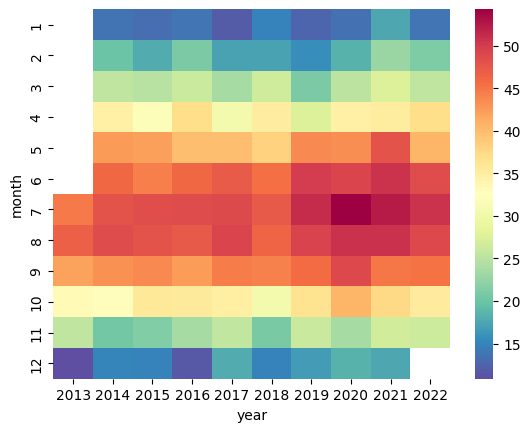

In [29]:
temp = pd.pivot_table(lst_df[['year','month','lst_c']], 
                      index='month', values='lst_c', columns='year')
sns.heatmap(temp, cmap='Spectral_r');

<br>

By default Earth Engine returns a series of images for each date in the time range we specified. To get a singular image we can either aggregate metrics across the series (e.g. get the mean, ma, total values by pixel), or select a specific image in the series (e.g. the first or last)

In [30]:
# Reduce the LST collection by mean.
lst_img = lst.mean()
# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)
# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

To download an image to python we need to get a url of the image from EE

In [31]:
# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 25, 'max': 40, 'dimensions': 512, 'region': aoi,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']})
print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39a2e864eb404f857ade921d294f542f-a2d9ce0fd46562c29fe57c794f5ba949:getPixels


In [33]:
# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
disp.Image(url=url)


Please wait while the thumbnail loads, it may take a moment...


# Plot the satellite data on a map in Folium

In [34]:
from itertools import chain

Get a centroid from our GeoJSON of the area of interest

In [35]:
ct = Polygon(list(chain(geo['features'][0]['geometry']['coordinates'][0]))).centroid

In [36]:
ct.x, ct.y

(38.78386781532498, 34.94804426958253)

In [37]:
# Define the center of our map.
lat, lon = ct.y, ct.x

my_map = folium.Map(location=[lat, lon], zoom_start=7)
my_map

In [38]:
# Helper function to add satellite data to Folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [39]:
# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 25, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

In [40]:
ee_tiles = [lst_img]
ee_vis_params = [lst_vis_params]
ee_tiles_names = ['Land Surface Temperature']

In [41]:
my_map = folium.Map(location=[lat, lon], zoom_start=7, tiles="Stamen Toner")
# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

In [42]:
# get the first of the month for each of the observations
lst_df['month_start'] = lst_df['datetime'].to_numpy().astype('datetime64[M]')

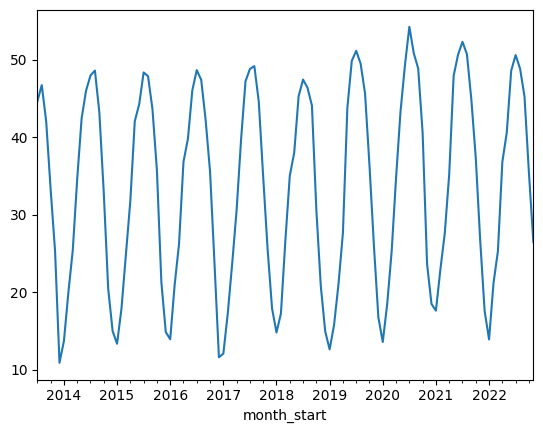

In [43]:
# plot the mean LST by month
lst_df.groupby('month_start')['lst_c'].mean().plot();

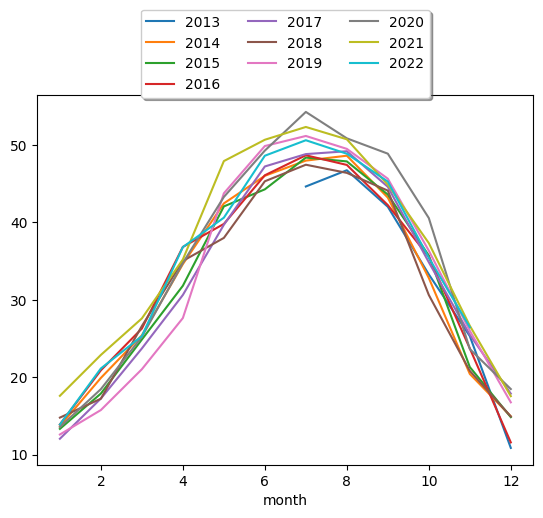

In [70]:
grouped = lst_df.groupby(['year', 'month'])['lst_c'].mean().reset_index()
grouped = pd.pivot_table(grouped, index="month", columns="year", values="lst_c")
sns.lineplot(data=grouped, dashes=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=3, fancybox=True, shadow=True);

<br>
<br>
<br>

# Appendix: Add conflict data to LST map

We can easily layer in other data sources in the Folium LST map. The below example gets data from the [Uppsala Conflict Data Program](https://ucdp.uu.se/downloads/index.html#ged_global) on conflict locations around the wold. We filter the data to those taken place in Syria and use a KDE plot to show the density of conflict zones in relation to LST.

In [71]:
ucdp = pd.read_csv('/Users/carlo.bailey/Downloads/GEDEvent_v23_1.csv')
ucdp.shape

/var/folders/gb/1fqzwzyx2qscq3bq5w41zbf80000gp/T/ipykernel_65743/352144413.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv('/Users/carlo.bailey/Downloads/GEDEvent_v23_1.csv')


(316818, 49)

In [72]:
mask = (ucdp['country']=='Syria') & (ucdp['date_start']>'2013-06-30')
ucdp = ucdp.loc[mask]
ucdp['date_start'] = ucdp['date_start'].to_numpy().astype('datetime64[M]')

In [73]:
ucdp = ucdp[ucdp['number_of_sources']>=6]

In [74]:
ucdp.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
205213,153777,IRQ-2014-1-448-630.2,2014,1,Clear,1,259,259,Iraq: Government,524,...,2014-09-23 00:00:00.000,0,23,2,0,25,24,25,645.0,NaN
205214,153778,IRQ-2014-1-448-630.3,2014,1,Clear,1,259,259,Iraq: Government,524,...,2014-09-23 00:00:00.000,0,23,1,0,24,25,25,645.0,NaN
205506,153201,AFG-2014-1-360-3,2014,1,Clear,1,418,418,United States of America: Government,878,...,2014-09-23 00:00:00.000,0,57,4,0,61,61,61,2.0,NaN
205507,293160,USA-2014-1-878-4,2014,1,Clear,1,418,418,United States of America: Government,878,...,2014-09-23 00:00:00.000,0,13,13,0,26,29,20,2.0,NaN
205509,153647,USA-2014-1-878-1,2014,1,Clear,1,418,418,United States of America: Government,878,...,2014-11-06 00:00:00.000,0,0,6,0,6,6,4,2.0,NaN


In [75]:
ucdp['points'] = ucdp.apply(lambda x: Point([x['longitude'], x['latitude']]), axis=1)

In [76]:
ucdp = gpd.GeoDataFrame(ucdp, geometry='points', crs='EPSG:4326')

In [77]:
ucdp.shape

(257, 50)

<Axes: >

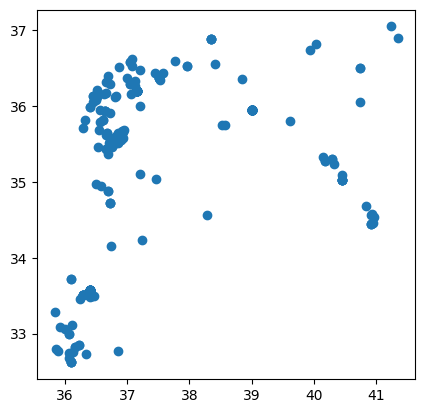

In [78]:
ucdp.plot()

In [79]:
my_map = folium.Map(location=[lat, lon], zoom_start=7, tiles="Cartodb dark_matter")
# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in ucdp.points]
plugins.HeatMap(heat_data, name='Conflict Zones').add_to(my_map)
folium.LayerControl(collapsed = False).add_to(my_map)
my_map